# Sentiment Classification

### Task
* IMDB 영화사이트에서 50000개의 영화평을 가지고 positive/negative인지 구분해보자.
* 데이터 불러오기를 제외한 딥러닝 트레이닝 과정을 직접 구현해보는 것이 목표 입니다.

### Dataset
* [IMDB datasets](https://www.imdb.com/interfaces/)

### Base code
* Dataset: train, val, test로 split
* Input data shape: (`batch_size`, `max_sequence_length`)
* Output data shape: (`batch_size`, 1)
* Architecture:
  * RNN을 이용한 간단한 classification 모델 가이드
  * `Embedding` - `SimpleRNN` - `Dense (with Sigmoid)`
  * [`tf.keras.layers`](https://www.tensorflow.org/api_docs/python/tf/keras/layers) 사용
* Training
  * `model.fit` 사용
* Evaluation
  * `model.evaluate` 사용 for test dataset

### Try some techniques
* Training-epochs 조절
* Change model architectures (Custom model)
  * Use another cells (LSTM, GRU, etc.)
  * Use dropout layers
* Embedding size 조절
  * 또는 one-hot vector로 학습
* Number of words in the vocabulary 변화
* `pad` 옵션 변화
* Data augmentation (if possible)

## 자연어처리에 관한 work flow

The flowchart of the algorithm is roughly:

<img src="https://user-images.githubusercontent.com/11681225/46912373-d2a3a800-cfae-11e8-8201-ef17b65834f5.png" alt="natural_language_flowchart" style="width: 300px;"/>

## Using tensorflow 2.1

In [25]:
!pip install tensorflow-gpu==2.1

## Import modules

In [0]:
use_colab = True
assert use_colab in [True, False]

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import os
import time
import shutil
import tarfile

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

import tensorflow as tf

from tensorflow.python.keras import layers

os.environ["CUDA_VISIBLE_DEVICES"]="0"

## Load Data

* IMDB에서 다운받은 총 50000개의 영화평을 사용한다.
* `tf.keras.datasets`에 이미 잘 가공된 데이터 셋이 있으므로 쉽게 다운받아 사용할 수 있다.
* 원래는 text 데이터이지만 `tf.keras.datasets.imdb`는 이미 Tokenizing이 되어있다.

In [0]:
# Load training and eval data from tf.keras
imdb = tf.keras.datasets.imdb

# 단어를 몇개까지 가져올것인가?
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words= 10000 )

train_labels = train_labels.astype(np.float64)
test_labels = test_labels.astype(np.float64)

### pickle error
* numpy 오류가 있어 데이터를 못읽어 오는 경우에 사용

In [0]:
# # save np.load
# np_load_old = np.load

# # modify the default parameters of np.load
# np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

# # call load_data with allow_pickle implicitly set to true
# (train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

# # restore np.load for future normal usage
# np.load = np_load_old


### Dataset details

In [31]:
print("Train-set size: ", len(train_data))
print("Test-set size:  ", len(test_data))

Train-set size:  25000
Test-set size:   25000


### Data 출력

In [33]:
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [32]:
print("sequence length: {}".format(len(train_data[0])))

sequence length: 218


* Label정보
  * 0.0 for a negative sentiment
  * 1.0 for a positive sentiment

In [34]:
# negative sample
index = 1
print("text: {}\n".format(train_data[index]))
print("label: {}".format(train_labels[index]))

text: [1, 194, 1153, 194, 8255, 78, 228, 5, 6, 1463, 4369, 5012, 134, 26, 4, 715, 8, 118, 1634, 14, 394, 20, 13, 119, 954, 189, 102, 5, 207, 110, 3103, 21, 14, 69, 188, 8, 30, 23, 7, 4, 249, 126, 93, 4, 114, 9, 2300, 1523, 5, 647, 4, 116, 9, 35, 8163, 4, 229, 9, 340, 1322, 4, 118, 9, 4, 130, 4901, 19, 4, 1002, 5, 89, 29, 952, 46, 37, 4, 455, 9, 45, 43, 38, 1543, 1905, 398, 4, 1649, 26, 6853, 5, 163, 11, 3215, 2, 4, 1153, 9, 194, 775, 7, 8255, 2, 349, 2637, 148, 605, 2, 8003, 15, 123, 125, 68, 2, 6853, 15, 349, 165, 4362, 98, 5, 4, 228, 9, 43, 2, 1157, 15, 299, 120, 5, 120, 174, 11, 220, 175, 136, 50, 9, 4373, 228, 8255, 5, 2, 656, 245, 2350, 5, 4, 9837, 131, 152, 491, 18, 2, 32, 7464, 1212, 14, 9, 6, 371, 78, 22, 625, 64, 1382, 9, 8, 168, 145, 23, 4, 1690, 15, 16, 4, 1355, 5, 28, 6, 52, 154, 462, 33, 89, 78, 285, 16, 145, 95]

label: 0.0


In [35]:
# positive sample
index = 200
print("text: {}\n".format(train_data[index]))
print("label: {}".format(train_labels[index]))

text: [1, 14, 9, 6, 227, 196, 241, 634, 891, 234, 21, 12, 69, 6, 6, 176, 7, 4, 804, 4658, 2999, 667, 11, 12, 11, 85, 715, 6, 176, 7, 1565, 8, 1108, 10, 10, 12, 16, 1844, 2, 33, 211, 21, 69, 49, 2009, 905, 388, 99, 2, 125, 34, 6, 2, 1274, 33, 4, 130, 7, 4, 22, 15, 16, 6424, 8, 650, 1069, 14, 22, 9, 44, 4609, 153, 154, 4, 318, 302, 1051, 23, 14, 22, 122, 6, 2093, 292, 10, 10, 723, 8721, 5, 2, 9728, 71, 1344, 1576, 156, 11, 68, 251, 5, 36, 92, 4363, 133, 199, 743, 976, 354, 4, 64, 439, 9, 3059, 17, 32, 4, 2, 26, 256, 34, 2, 5, 49, 7, 98, 40, 2345, 9844, 43, 92, 168, 147, 474, 40, 8, 67, 6, 796, 97, 7, 14, 20, 19, 32, 2188, 156, 24, 18, 6090, 1007, 21, 8, 331, 97, 4, 65, 168, 5, 481, 53, 3084]

label: 1.0


## Prepare dataset

### Convert the integers back to words

In [66]:
# A dictionary mapping words to an integer index
word_index = imdb.get_word_index()
[print(key) for key, value in word_index.items() if value in [0,1,2,3]]


# The first indices are reserved
# 앞에 태그를 달기 위해 dict를 3개씩 미뤄준다,
word_index = {k:(v+3) for k,v in word_index.items()} 

[print(key) for key, value in word_index.items() if value in [0,1,2,3]]

word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3


[print(key) for key, value in word_index.items() if value in [0,1,2,3]]

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])


print(type(word_index))
def decode_review(text):
  return ' '.join([reverse_word_index.get(i, '?') for i in text])


a
the
and
<PAD>
<START>
<UNK>
<UNUSED>
<class 'dict'>


#### Text data 출력

In [37]:
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [73]:
decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

In [14]:
decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

In [61]:
decode_review([1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5,])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and"

### Padding and truncating data using pad sequences

In [0]:
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

In [0]:
num_seq_length = np.array([len(tokens) for tokens in list(train_data) + list(test_data)])
train_seq_length = np.array([len(tokens) for tokens in train_data], dtype=np.int32)
test_seq_length = np.array([len(tokens) for tokens in test_data], dtype=np.int32)

In [0]:
max_seq_length = 256

In [68]:
print(np.sum(num_seq_length < max_seq_length) / len(num_seq_length))

0.70518


* `max_seq_length`을 256으로 설정하면 전체 데이터 셋의 70%를 커버할 수 있다.
* 30% 정도의 데이터가 256 단어가 넘는 문장으로 이루어져 있다.
* 보통 미리 정한 `max_seq_length`를 넘어가는 문장의 데이터는 *truncate* 한다.

In [0]:
# padding 옵션은 두 가지가 있다.

# padding 을 앞에 준건 rnn layer특징상 맨뒤의 context가 영향력이 가장 크므로,
# 또 앞에 word들의 중요도가 gradient vanising 문제로 
pad = 'pre'
# pad = 'post'

In [0]:
train_data_pad = pad_sequences(train_data,
                               maxlen=max_seq_length,
                               padding=pad,
                               value=word_index["<PAD>"])
test_data_pad = pad_sequences(test_data,
                              maxlen=max_seq_length,
                              padding=pad,
                              value=word_index["<PAD>"])

In [0]:
#### 이렇게 쓰는건가?/ ####

### value 는 무엇인가?

pad_example = pad_sequences([1,2,3,4],
                            maxlen=10,
                            padding='post',
                            value=word_index["<PAD>")

In [71]:
print(train_data_pad.shape)
print(test_data_pad.shape)

(25000, 256)
(25000, 256)


#### Padding data 출력

In [72]:
index = 0
print("text: {}\n".format(decode_review(train_data[index])))
print("token: {}\n".format(train_data[index]))
print("pad: {}".format(train_data_pad[index]))

text: <START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised f

### Create a validation set

In [0]:
num_val_data = 5000
val_data_pad = train_data_pad[:num_val_data]
train_data_pad_partial = train_data_pad[num_val_data:]

val_labels = train_labels[:num_val_data]
train_labels_partial = train_labels[num_val_data:]

## Setup hyper-parameters

In [75]:
tokenizer.word_index

NameError: ignored

In [0]:
# Set the hyperparameter set
# vocab_size : 10000
# embedding_size : 100 ~ 256 이 좋을듯

batch_size = 512
learning_rate = 1e-3
max_epochs = 10
embedding_size = 256
vocab_size = 10000

# the save point
if use_colab:
    checkpoint_dir ='./drive/My Drive/train_ckpt/sentimental/exp1'
    if not os.path.isdir(checkpoint_dir):
        os.makedirs(checkpoint_dir)
else:
    checkpoint_dir = 'sentimental/exp1'

## Build the model

### Embedding layer

* embedding-layer는 전체 vocabulary의 갯수(num_words)로 이루어진 index가 `embedding_size`의 *dense vector* 로 변환되는 과정이다.

### Main rnn model

In [0]:
# model.add 를 통해 자유롭게 모델을 만들어보세요.
# TODO
model = tf.keras.Sequential()

# TODO
model.add(layers.Embedding(vocab_size, embedding_size))

model.add(layers.LSTM(256, return_sequences = True))
model.add(layers.LSTM(10, return_sequences = False))

### Classification layer

In [0]:
# TODO
model.add(layers.Dense(1, activation='sigmoid'))

In [136]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 256)         2560000   
_________________________________________________________________
lstm_7 (LSTM)                (None, None, 256)         525312    
_________________________________________________________________
lstm_8 (LSTM)                (None, 10)                10680     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 3,096,003
Trainable params: 3,096,003
Non-trainable params: 0
_________________________________________________________________


### Compile the model

In [0]:
optimizer = tf.keras.optimizers.Adam()

In [0]:
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

### checkpoints

In [0]:
if not tf.io.gfile.exists(checkpoint_dir):
    tf.io.gfile.makedirs(checkpoint_dir)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=model)

## Train the model

In [140]:
# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_data_pad_partial, train_labels_partial))
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_data_pad, test_labels))
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)

# for valid
valid_dataset = tf.data.Dataset.from_tensor_slices((val_data_pad, val_labels))
valid_dataset = valid_dataset.batch(batch_size=batch_size)
print(valid_dataset)

<BatchDataset shapes: ((None, 256), (None,)), types: (tf.int32, tf.float64)>
<BatchDataset shapes: ((None, 256), (None,)), types: (tf.int32, tf.float64)>
<BatchDataset shapes: ((None, 256), (None,)), types: (tf.int32, tf.float64)>


In [141]:
len(val_data_pad) , len(train_data_pad_partial)

(5000, 20000)

In [142]:
%%time
history = model.fit(train_dataset,
                    epochs= max_epochs, 
                    validation_data=valid_dataset,
                    steps_per_epoch= len(train_data_pad_partial)/batch_size,
                    validation_steps= len(val_data_pad)/batch_size
                    )


Train for 39.0625 steps, validate for 9.765625 steps
Epoch 1/10
40/39 [==============================] - 493s 12s/step - loss: 0.5834 - accuracy: 0.7046 - val_loss: 0.4573 - val_accuracy: 0.8096
Epoch 2/10
40/39 [==============================] - 489s 12s/step - loss: 0.3948 - accuracy: 0.8421 - val_loss: 0.4169 - val_accuracy: 0.8354
Epoch 3/10
40/39 [==============================] - 491s 12s/step - loss: 0.3262 - accuracy: 0.8733 - val_loss: 0.4932 - val_accuracy: 0.7750
Epoch 4/10
40/39 [==============================] - 514s 13s/step - loss: 0.2479 - accuracy: 0.9116 - val_loss: 0.3965 - val_accuracy: 0.8422
Epoch 5/10
40/39 [==============================] - 507s 13s/step - loss: 0.1798 - accuracy: 0.9416 - val_loss: 0.3755 - val_accuracy: 0.8596
Epoch 6/10
40/39 [==============================] - 504s 13s/step - loss: 0.1668 - accuracy: 0.9465 - val_loss: 0.3993 - val_accuracy: 0.8442
Epoch 7/10
40/39 [==============================] - 497s 12s/step - loss: 0.1532 - accuracy: 0.

In [143]:
checkpoint.save(file_prefix = checkpoint_prefix)

'./drive/My Drive/train_ckpt/sentimental/exp1/ckpt-1'

## Performance on Test-Set

Now that the model has been trained we can calculate its classification accuracy on the test-set.

In [144]:
checkpoint = tf.train.Checkpoint(model=model)
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [145]:
results = model.evaluate(test_dataset)
# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.3f}".format(results[1]))

49/49 [==============================] - 148s 3s/step - loss: 0.6099 - accuracy: 0.8332
loss value: 0.610
accuracy value: 0.833


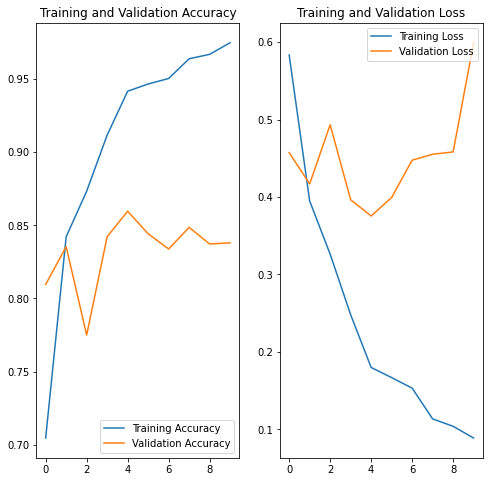

In [146]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(max_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()